In [101]:
import sys
import os
import numpy as np
import xarray as xr
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.metrics import brier_score_loss
from sklearn.linear_model import LogisticRegression

sys.path.append(os.path.expanduser('~/Documents/Hybrid/'))
from Hybrid.neuralnet import construct_modeldev_model, earlystop, BrierScore, ConstructorAndCompiler
#from Hybrid.optimization import multi_fit_multi_eval, multi_fit_single_eval, ranked_prob_score
from Hybrid.dataprep import test_trainval_split, multiclass_log_forecastprob, singleclass_regression, multiclass_logistic_regression_coefficients, scale_other_features, scale_time
from Hybrid.interpretation import combine_input_output, composite_extremes

sys.path.append(os.path.expanduser('~/Documents/Weave/'))
from Weave.utils import reliability_plot

crossval = True # Only for the trainvalsplit.
nfolds = 3
balanced = True
focus_class = -1 # Index of the class to be scored and benchmarked through bss

name = 'tg-anom_JJA_45r1_31D-roll-mean_q05_sep12-15'
#name = 'tg-ex-q0.75-21D_ge7D_sep12-15'
#name2 = 'tg-anom_JJA_45r1_21D-roll-mean_sep12-15'

predictor_dir = Path('/nobackup/users/straaten/predsets/objective_balanced_cv/') # Can change to the objectively selected sets
#predictor_dir = Path('/nobackup/users/straaten/predsets/objective_balanced_cv/emp_duplicated/') # Can change to the objectively selected sets
for_obs_dir = Path('/nobackup/users/straaten/predsets/full/') 

predictors = pd.read_hdf(predictor_dir / f'{name}_multi_d20_b3_predictors.h5', key = 'input').iloc[:,:4]
forc = pd.read_hdf(for_obs_dir / f'{name}_forc.h5', key = 'input')
obs= pd.read_hdf(for_obs_dir / f'{name}_obs.h5', key = 'target')

In [102]:
# Splitting the sets.
X_test, X_trainval, generator = test_trainval_split(predictors, crossval = crossval, nfolds = nfolds, balanced = balanced)
forc_test, forc_trainval, generator = test_trainval_split(forc, crossval = crossval, nfolds = nfolds, balanced = balanced)
obs_test, obs_trainval, generator = test_trainval_split(obs, crossval = crossval, nfolds = nfolds, balanced = balanced)

# Prepare trainval data for the neural network
features_trainval, feature_scaler = scale_other_features(X_trainval)
logforc_trainval = multiclass_log_forecastprob(forc_trainval)
obsinp_trainval = obs_trainval.values

# Preparing the test set
features_test, _ = scale_other_features(X_test, fitted_scaler=feature_scaler)
logforc_test = multiclass_log_forecastprob(forc_test)

fitting a new feature scaler
using a pre-fitted feature scaler


In [104]:
# Setting up the model
construct_kwargs = dict(n_classes = obs_trainval.shape[-1],
        n_hidden_layers= 1,
        n_features = features_trainval.shape[-1],
        n_hiddenlayer_nodes = 4)

compile_kwargs = dict(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0014),
        metrics = ['accuracy',BrierScore(class_index = focus_class)])

constructor = ConstructorAndCompiler(construct_modeldev_model, construct_kwargs, compile_kwargs)

fit_kwargs = dict(batch_size = 32, epochs = 200, shuffle = True, callbacks = [earlystop(patience = 7, monitor = 'val_loss')])

In [105]:
# Training the model


# Training a trend benchmark model, and generating scale test time input
time_input, time_scaler, lr = singleclass_regression(obs_trainval.iloc[:,focus_class], regressor = LogisticRegression)
time_test, _ = scale_time(obs_test, fitted_scaler=time_scaler)

fitting a new time scaler
using a pre-fitted time scaler


In [109]:
# Generating model predictions:

# Generating benchmark predictions:
trend_test = lr.predict(time_test)
trend_trainval = lr.predict(time_input)

In [ ]:
n_iter = 2000
bs = pd.DataFrame(np.nan, columns = pd.MultiIndex.from_product([['trainval','test'],['raw','trend','neural']], names = ['set','forecast']), index = pd.RangeIndex(n_iter))
for i in range(n_iter):
    model = constructor.fresh_model()
    model.fit(x = [features_trainval, logforc_trainval], y=obsinp_trainval, validation_split = 0.33, **fit_kwargs)
    
    preds_test = model.predict(x = [features_test, logforc_test])
    preds_trainval = model.predict(x = [features_trainval, logforc_trainval])
    
    train_sample = np.random.randint(low = 0, high = obs_trainval.shape[0], size = obs_trainval.shape[0]) # bootstrap sample with replacement.
    test_sample = np.random.randint(low = 0, high = obs_test.shape[0], size = obs_test.shape[0])
    
    bs.loc[i,('test','raw')] = brier_score_loss(obs_test.values[test_sample,focus_class],forc_test.values[test_sample,focus_class])
    bs.loc[i,('test','trend')] = brier_score_loss(obs_test.values[test_sample,focus_class],trend_test[test_sample])
    bs.loc[i,('test','neural')] = brier_score_loss(obs_test.values[test_sample,focus_class],preds_test[test_sample,focus_class])
    
    bs.loc[i,('trainval','raw')] = brier_score_loss(obs_trainval.values[train_sample,focus_class],forc_trainval.values[train_sample,focus_class])
    bs.loc[i,('trainval','trend')] = brier_score_loss(obs_trainval.values[train_sample,focus_class],trend_trainval[train_sample])
    bs.loc[i,('trainval','neural')] = brier_score_loss(obs_trainval.values[train_sample,focus_class],preds_trainval[train_sample,focus_class])

# scale test and trainval BS separately based on the mean raw score
bs['test'] = bs['test'] - float(bs[('test', 'raw')].mean())
bs['trainval'] = bs['trainval'] - float(bs[('trainval', 'raw')].mean())

Epoch 1/200
41/41 [==============================] - 0s 3ms/step - loss: 0.7248 - accuracy: 0.5498 - brier: 0.2615 - val_loss: 0.7830 - val_accuracy: 0.4826 - val_brier: 0.2881
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.7096 - accuracy: 0.5848 - brier: 0.2519 - val_loss: 0.7660 - val_accuracy: 0.4905 - val_brier: 0.2810
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6655 - accuracy: 0.6330 - brier: 0.2314 - val_loss: 0.7390 - val_accuracy: 0.5221 - val_brier: 0.2691
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6242 - accuracy: 0.6781 - brier: 0.2122 - val_loss: 0.7112 - val_accuracy: 0.5315 - val_brier: 0.2573
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5954 - accuracy: 0.7107 - brier: 0.1991 - val_loss: 0.6909 - val_accuracy: 0.5820 - val_brier: 0.2482
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5763 - accuracy: 0.7247 - brier: 0.1904 

Epoch 10/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5425 - accuracy: 0.7566 - brier: 0.1752 - val_loss: 0.6482 - val_accuracy: 0.6104 - val_brier: 0.2288
Epoch 11/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5417 - accuracy: 0.7613 - brier: 0.1746 - val_loss: 0.6367 - val_accuracy: 0.6009 - val_brier: 0.2259
Epoch 12/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5394 - accuracy: 0.7543 - brier: 0.1735 - val_loss: 0.6357 - val_accuracy: 0.6104 - val_brier: 0.2243
Epoch 13/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5407 - accuracy: 0.7558 - brier: 0.1738 - val_loss: 0.6356 - val_accuracy: 0.6136 - val_brier: 0.2238
Epoch 14/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5367 - accuracy: 0.7574 - brier: 0.1723 - val_loss: 0.6332 - val_accuracy: 0.6136 - val_brier: 0.2230
Epoch 15/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5367 - accuracy: 0.7628 - brier: 0

41/41 [==============================] - 0s 1ms/step - loss: 0.5375 - accuracy: 0.7613 - brier: 0.1726 - val_loss: 0.6294 - val_accuracy: 0.6246 - val_brier: 0.2215
Epoch 16/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5372 - accuracy: 0.7621 - brier: 0.1724 - val_loss: 0.6245 - val_accuracy: 0.6120 - val_brier: 0.2202
Epoch 17/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5386 - accuracy: 0.7589 - brier: 0.1723 - val_loss: 0.6236 - val_accuracy: 0.6199 - val_brier: 0.2204
Epoch 18/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5359 - accuracy: 0.7574 - brier: 0.1719 - val_loss: 0.6251 - val_accuracy: 0.6230 - val_brier: 0.2199
Epoch 19/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5352 - accuracy: 0.7597 - brier: 0.1713 - val_loss: 0.6266 - val_accuracy: 0.6293 - val_brier: 0.2200
Epoch 20/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5346 - accuracy: 0.7613 - brier: 0.1710 - val_l

Epoch 27/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5339 - accuracy: 0.7644 - brier: 0.1705 - val_loss: 0.6262 - val_accuracy: 0.6309 - val_brier: 0.2198
Epoch 28/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5328 - accuracy: 0.7566 - brier: 0.1700 - val_loss: 0.6233 - val_accuracy: 0.6293 - val_brier: 0.2192
Epoch 29/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5343 - accuracy: 0.7589 - brier: 0.1705 - val_loss: 0.6290 - val_accuracy: 0.6356 - val_brier: 0.2207
Epoch 30/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5332 - accuracy: 0.7566 - brier: 0.1701 - val_loss: 0.6299 - val_accuracy: 0.6341 - val_brier: 0.2211
Epoch 31/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5326 - accuracy: 0.7675 - brier: 0.1695 - val_loss: 0.6214 - val_accuracy: 0.6309 - val_brier: 0.2186
Epoch 32/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5358 - accuracy: 0.7605 - brier: 0

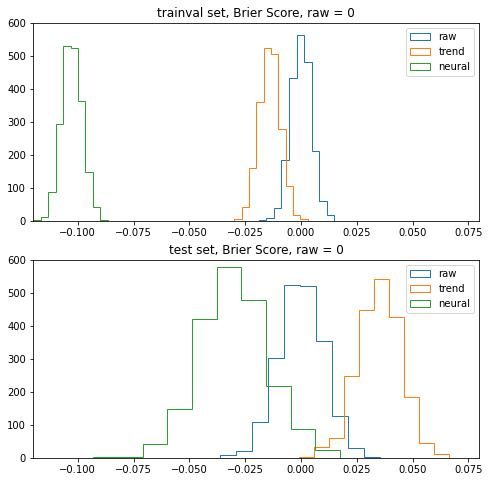

In [95]:
fig, axes = plt.subplots(ncols=1, nrows = 2, figsize = (8,8), squeeze = False)
for key in bs.columns:
    i = bs.columns.get_level_values(0).unique().tolist().index(key[0])
    ax = axes[i,0]
    ax.hist(bs[key], label = key[-1], histtype = 'step')
    ax.set_xlim(left = -0.12, right = 0.08)
    ax.set_ylim(0,600)
    ax.set_title(f'{key[0]} set, Brier Score, raw = 0')
    ax.legend()

In [96]:
complete_test = pd.DataFrame({'raw':forc_test.iloc[:,focus_class], 'trend': trend_test,'neural':preds_test[:,focus_class]}, index = forc_test.index)
complete_test.columns.name = 'type'

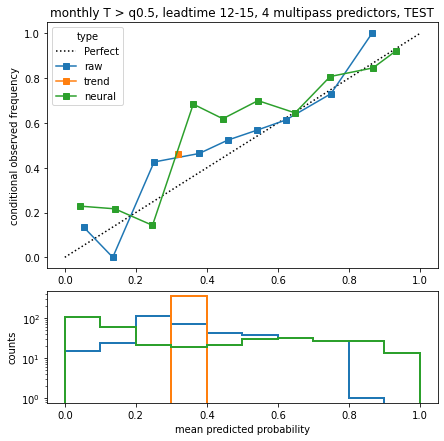

In [97]:
fig, (axrel, axhist) = reliability_plot(y_true = obs_test.iloc[:,focus_class], y_probs=complete_test)
axrel.set_title('monthly T > q0.5, leadtime 12-15, 4 multipass predictors, TEST')
plt.show()

In [98]:
complete_train = pd.DataFrame({'raw':forc_trainval.iloc[:,focus_class],'trend': trend_trainval,'neural':preds_trainval[:,focus_class]}, index = forc_trainval.index)
complete_train.columns.name = 'type'

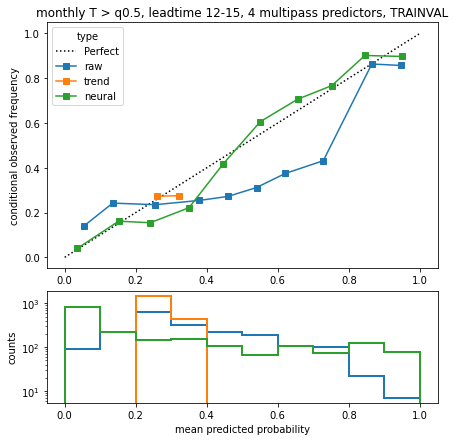

In [99]:
fig, (axrel, axhist) = reliability_plot(y_true = obs_trainval.iloc[:,focus_class], y_probs =complete_train)
axrel.set_title('monthly T > q0.5, leadtime 12-15, 4 multipass predictors, TRAINVAL')
plt.show()